In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
df = pd.read_csv('../data/raw/clinical_data_lung.zip')

In [103]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Survival months flags

Esta columna es el "control de calidad" de SEER. muestra confiable es el dato de los meses de vida. Para un modelo de Machine Learning, la calidad del dato es más importante que la cantidad, por lo que aquí debemos ser selectivos.

In [104]:
df["Survival months flag"].value_counts()

Survival months flag
Complete dates are available and there are more than 0 days of survival      514829
Not calculated because a Death Certificate Only or Autopsy Only case          13051
Incomplete dates are available and there cannot be zero days of follow-up      6503
Complete dates are available and there are 0 days of survival                  2092
Incomplete dates are available and there could be zero days of follow-up        943
Name: count, dtype: int64

la clasificacion "Not calculated because a Death Certificate Only or Autopsy Only"  Solo se supo del cáncer cuando la persona murió (por la autopsia o el certificado) no genera ruido al modelo  ya que estas personas no pudieron ser sometidas a tratamientos ni fueron sometidas a un proceso de analisis

la clasificacion "Incomplete dates are available and there could be zero days of follow-up" indica:

Fechas Incompletas: El registro médico puede decir "Enero de 2015" pero no el día, o simplemente "2015".

Cero días de seguimiento: Al no haber fechas exactas, el sistema marca "0", pero existe la posibilidad de que el paciente haya vivido algunos días o semanas que no quedaron registrados.

Seguimiento (Follow-up): Indica que el paciente "desapareció" del radar del hospital justo después del diagnóstico.

In [105]:
# 1. características a eliminar
a_eliminar = ['Not calculated because a Death Certificate Only or Autopsy Only case', 'Incomplete dates are available and there cannot be zero days of follow-up','Incomplete dates are available and there could be zero days of follow-up']

# 2. Sobreescribimos el dataframe filtrando: "Manten los que NO estén en la lista"
df = df[~df['Survival months flag'].isin(a_eliminar)]

In [106]:
df["Survival months flag"].value_counts()

Survival months flag
Complete dates are available and there are more than 0 days of survival    514829
Complete dates are available and there are 0 days of survival                2092
Name: count, dtype: int64

In [107]:
df["Survival months"].value_counts()

Survival months
0000    58953
0001    43091
0002    31499
0003    23635
0004    20196
0005    16886
0006    16406
0007    14735
0008    13556
0009    13242
0010    11651
0011    10899
0012     9762
0013     9262
0014     8486
0015     7682
0016     7669
0018     6882
0017     6874
0019     6148
0020     6089
0021     5505
0022     5247
0023     4840
0024     4689
0025     4460
0027     4381
0026     4241
0028     3907
0029     3851
0030     3704
0034     3423
0033     3350
0035     3196
0036     3114
0031     3113
0038     3071
0032     2928
0037     2882
0041     2771
0039     2722
0040     2700
0042     2563
0043     2533
0044     2484
0045     2484
0046     2346
0047     2244
0050     2137
0052     2113
0049     2106
0048     2099
0054     1920
0056     1885
0051     1870
0053     1839
0055     1802
0057     1757
0059     1708
0058     1662
0061     1616
0062     1580
0064     1562
0060     1514
0063     1483
0066     1477
0069     1421
0067     1394
0070     1385
0065     1382
0068

In [108]:
df = df[~(df["Survival months"] == "Unknown")]

# Analisis de variables

# 1. Variables Demográficas y Socioeconómicas

## Eliminacion de columnas que no son de valor significativo

In [109]:
columns_to_drop = ["Type of Reporting Source", 
                   "Grade Clinical (2018+)",
                   "Sequence number",
                   "Primary Site"]
#df = df.drop(columns=columns_to_drop)

#### Observaciones:
> - `Race and origin (recommended by SEER)` se elimina debido a que es una etiqueta general.
> - `Type of Reporting Source` se elimina debido a la dominancia excesiva de (Hospital inpatient/outpatient or clinic) y categorías minoritarias como (Autopsy only) con apenas 454 registros.
> - `Diagnostic Confirmation`  una vez limpio el conjunto de datos de estos registros no validados por diagnósticos se elimina la columna.
> - `Origin recode NHIA (Hispanic, Non-Hisp)`  Esa informacion solo contiene 2 tipos de caracteristicas prenominando una de ellas con mas del 90% de los datos
> - `PRCDA 2020` Indirectamente, PRCDA suele estar asociada a zonas más rurales o comunidades específicas, Esta variable está fuertemente ligada a la raza (American Indian/Alaska Native), al tener una variable que ya nos clasifica las razas esta no es necesaria
> - `Primary Site` existe otra variable que tambien refleja donde comenzo a crecer el tumor  

Filas duplicadas

In [110]:
df.duplicated().sum()

np.int64(575)

In [111]:
df.drop_duplicates(inplace=True)     

## Age 

In [112]:
df.groupby("Age recode with <1 year olds and 90+")["Vital status recode (study cutoff used)"].value_counts().unstack().fillna(0)

Vital status recode (study cutoff used),Alive,Dead
Age recode with <1 year olds and 90+,,
00 years,19,1
01-04 years,32,5
05-09 years,14,3
10-14 years,28,7
15-19 years,66,17
20-24 years,139,55
25-29 years,246,123
30-34 years,427,307
35-39 years,758,740


se puede observar que las edades estan divididas en en rango de edades de 5 años aproximadamente, se procedera a reagrupar a las personas en grupos mas grandes siguiendo una lógica fisiológica y clínica.
 
Grupo 1 (0-19 años): Pediátrico/Adolescente. Cánceres con biología muy distinta y alta tasa de supervivencia en muchos casos.

Grupo 2 (20-39 años): Adulto Joven. Pacientes con pocas comorbilidades (otras enfermedades) pero donde el cáncer puede ser más agresivo.

Grupo 3 (40-59 años): Adulto Medio. La etapa donde aumenta la incidencia; es el "estándar" del dataset.

Grupo 4 (60-75 años): Adulto Mayor. Comienzan a aparecer otros problemas de salud que afectan el tratamiento.

Grupo 5 (>75 años): Gerátrico. El riesgo de mortalidad no relacionada con el cáncer es muy alto y los tratamientos suelen ser menos invasivos.

In [113]:
# agregar una columna de grupo de edades 

# 1. Definimos los rangos para cada grupo
grupo_1 = ['00 years', '01-04 years', '05-09 years', '10-14 years', '15-19 years']
grupo_2 = ['20-24 years', '25-29 years', '30-34 years', '35-39 years']
grupo_3 = ['40-44 years','45-49 years', '50-54 years', '55-59 years']
grupo_4 =['60-64 years','65-69 years', '70-74 years']
# El resto (65+) caerá en el grupo 5

# 2. Función lógica para asignar el grupo
def asignar_grupo(edad):
    if edad in grupo_1: return 1
    if edad in grupo_2: return 2
    if edad in grupo_3: return 3
    if edad in grupo_4: return 4
    return 5  # Todo lo que no esté en los anteriores (80+)

# 3. Creamos la columna
df['age_group'] = df['Age recode with <1 year olds and 90+'].apply(asignar_grupo)

# 4. Verificamos los conteos
df['age_group'].value_counts().sort_index()

age_group
1       192
2      2795
3     77734
4    249759
5    185866
Name: count, dtype: int64

al tener una nueva columna con las edades divididas en grupos no necesitamos la anterior por tal motivo procedemos a eliminarla

In [114]:
# Eliminamos la columna original de edad
df.drop('Age recode with <1 year olds and 90+', axis=1, inplace=True)

## sex

In [115]:
df.groupby("Sex")["Vital status recode (study cutoff used)"].value_counts().unstack().fillna(0)

Vital status recode (study cutoff used),Alive,Dead
Sex,,
Female,83305,169953
Male,63637,199451


## Race recode (White, Black, Other)

In [116]:
# cambiar el nombre de la columna a Race
df.rename(columns={'Race recode (White, Black, Other)': 'Race'}, inplace=True)

df["Race"].value_counts()



Race
White                                                        417788
Black                                                         55210
Other (American Indian/AK Native, Asian/Pacific Islander)     41656
Unknown                                                        1692
Name: count, dtype: int64

Se observan 4 tipos de caracteristicas, agruparemos  las caracteristicas de Other con Unknown en una sola caracteristica "Other"

In [117]:
# Definimos la lista de las categorías que queremos agrupar
a_renombrar = ['Other (American Indian/AK Native, Asian/Pacific Islander)', 'Unknown']

# Reemplazamos esos valores por 'Other'
df['Race'] = df['Race'].replace(a_renombrar, 'Other')

In [118]:
df.groupby("Race")["Vital status recode (study cutoff used)"].value_counts().unstack().fillna(0)

Vital status recode (study cutoff used),Alive,Dead
Race,,
Black,14386,40824
Other,15678,27670
White,116878,300910


## 'Rural-Urban Continuum Code'

In [119]:
df['Rural-Urban Continuum Code'].value_counts().sort_index()

Rural-Urban Continuum Code
Counties in metropolitan areas ge 1 million pop                 279449
Counties in metropolitan areas of 250,000 to 1 million pop      109368
Counties in metropolitan areas of lt 250 thousand pop            45091
Nonmetropolitan counties adjacent to a metropolitan area         47954
Nonmetropolitan counties not adjacent to a metropolitan area     33663
Unknown/missing/no match (Alaska or Hawaii - Entire State)         808
Unknown/missing/no match/Not 1990-2023                              13
Name: count, dtype: int64

In [120]:
df.groupby("Rural-Urban Continuum Code")["Vital status recode (study cutoff used)"].value_counts().unstack().fillna(0)

Vital status recode (study cutoff used),Alive,Dead
Rural-Urban Continuum Code,,
Counties in metropolitan areas ge 1 million pop,85820,193629
"Counties in metropolitan areas of 250,000 to 1 million pop",30853,78515
Counties in metropolitan areas of lt 250 thousand pop,11119,33972
Nonmetropolitan counties adjacent to a metropolitan area,11829,36125
Nonmetropolitan counties not adjacent to a metropolitan area,7144,26519
Unknown/missing/no match (Alaska or Hawaii - Entire State),170,638
Unknown/missing/no match/Not 1990-2023,7,6


podemos observar que las dos clasificaciones desconocidas ademas de tener pocos datos no se consideran muy relevantes el porcentaje de personas vivas al final de  la ultima fecha de estudio por tal motivo procederan a eliminarse y tambien cambiaremos el nombre de la columna a "Rural Code"

In [121]:
df.rename(columns={'Rural-Urban Continuum Code': 'Rural Code'}, inplace=True)

# 1. características a eliminar
a_eliminar = ['Unknown/missing/no match (Alaska or Hawaii - Entire State)', 'Unknown/missing/no match/Not 1990-2023']

# 2. Sobreescribimos el dataframe filtrando: "Manten los que NO estén en la lista"
df = df[~df['Rural Code'].isin(a_eliminar)]

In [122]:
df['Rural Code'].value_counts()

Rural Code
Counties in metropolitan areas ge 1 million pop                 279449
Counties in metropolitan areas of 250,000 to 1 million pop      109368
Nonmetropolitan counties adjacent to a metropolitan area         47954
Counties in metropolitan areas of lt 250 thousand pop            45091
Nonmetropolitan counties not adjacent to a metropolitan area     33663
Name: count, dtype: int64

## Median household income inflation adj to 2023

In [123]:
df['Median household income inflation adj to 2023'].unique()


array(['$120,000+', '$110,000 - $119,999', '$100,000 - $109,999',
       '$95,000 - $99,999', '$90,000 - $94,999', '$85,000 - $89,999',
       '$80,000 - $84,999', '$75,000 - $79,999', '$70,000 - $74,999',
       '$65,000 - $69,999', '$60,000 - $64,999', '$55,000 - $59,999',
       '$50,000 - $54,999', '$45,000 - $49,999', '< $40,000',
       '$40,000 - $44,999'], dtype=object)

Propuesta de Reagrupación Óptima

Dividiremos los ingresos basándonos en la distribución típica de niveles de vida (Bajo, Medio-Bajo, Medio, Medio-Alto, Alto):

Grupo 1: Nivel Bajo (Menos de $45k) Representa a la población con mayores barreras económicas.

Grupo 2: Nivel Medio-Bajo ($45k - $64k)

Grupo 3: Nivel Medio ($65k - $84k)

Grupo 4: Nivel Medio-Alto ($85k - $109k)

Grupo 5: Nivel Alto (Más de $110k)

Incluye: $110,000 - $119,999 y $120,000+.

In [124]:
# Usaremos un diccionario de mapeo para asegurar que cada string se convierta exactamente en el número del grupo.

# Definimos el mapeo manual para asegurar precisión
map_ingresos = {
    '< $40,000': 1, '$40,000 - $44,999': 1,
    '$45,000 - $49,999': 2, '$50,000 - $54,999': 2, '$55,000 - $59,999': 2, '$60,000 - $64,999': 2,
    '$65,000 - $69,999': 3, '$70,000 - $74,999': 3, '$75,000 - $79,999': 3, '$80,000 - $84,999': 3,
    '$85,000 - $89,999': 4, '$90,000 - $94,999': 4, '$95,000 - $99,999': 4, '$100,000 - $109,999': 4,
    '$110,000 - $119,999': 5, '$120,000+': 5
}

# Creamos la nueva columna
df['income_level'] = df['Median household income inflation adj to 2023'].map(map_ingresos)


# df.groupby("income_level")["Vital status recode (study cutoff used)"].value_counts().unstack().fillna(0)


In [125]:
# Eliminamos la columna original de nivel de ingresos
df.drop('Median household income inflation adj to 2023', axis=1, inplace=True)

## SEER cause-specific death classification

In [126]:
# 1. características a eliminar
#df = df[(df['SEER cause-specific death classification'] == "Dead (missing/unknown COD)") & (df['survival_range'] >= 60)]
#df = df[df['SEER cause-specific death classification'] != "Dead (missing/unknown COD)"]

aqui tenemos tres tipos de clasificaciones:
personas muertas debido al  cancer, personas vivas o muertas por causas distintas a las del cancer y personas que han muerto pero la razon del fallecimiento es desconocida, para un mejor modelo e importante tener casos en los que son claros los fallecimientos, por tal motivo los casos en donde se desconoce la razon de muerte seran eliminados

In [127]:
# 1. características a eliminar
#df = df.drop("Vital status recode (study cutoff used)", axis=1)

# Definimos el mapeo según tus instrucciones
mapeo_muerte = {
    'Dead (attributable to this cancer dx)': 'dead',
    'Alive or dead of other cause': 'Alive',
    "Dead (missing/unknown COD)": 'dead_unknown'
}

# Aplicamos el cambio
df['SEER cause-specific death classification'] = df['SEER cause-specific death classification'].map(mapeo_muerte)

# Verificamos el resultado final

df['SEER cause-specific death classification'].value_counts()

SEER cause-specific death classification
dead            295060
Alive           216846
dead_unknown      3619
Name: count, dtype: int64

aqui podemos observar que entre las dos columnas que tenemos, la columna Vital status recode (study cutoff used) nos introduce ruido al modelo ya que solo clasifica a las personas por muertas y vivas por tal  motivo, nos quedaremos solo con las variables que nos separan a las personas por causas de muerte debido al cancer

una persona que ha muerto por causas ajenas al cancer (accidente u otra enfermedad) se puede considerar como viva al momento del ultimo seguimiento ya que su muerte no ha sido debido a la enfermedad del cancer por lo cual no se puede descartar que un tratamiento u operacion hubiese sido beneficioso.

Renombramos las caracteristicas de la clasificacion y el nombre de la  columna

In [128]:
df['target_cancer_death'] = df['SEER cause-specific death classification'].apply(
    lambda x: 1 if 'dead' in str(x) else 0
)

# Verificamos el balance de clases
df['target_cancer_death'].value_counts()

target_cancer_death
1    298679
0    216846
Name: count, dtype: int64

In [129]:
# renombramos la columna
df.rename(columns={'SEER cause-specific death classification': 'vital_status'}, inplace=True)

In [130]:
df = df[~(df["Survival months"] == "Unknown")]

In [131]:

# 1. Aseguramos que sea entero
df['survival_months_int'] = pd.to_numeric(df['Survival months'], errors='coerce').fillna(0).astype(int)

# 2. Definir la nueva función con rangos mixtos (de 5 en 5 y luego de 10 en 10)
def agrupar_supervivencia_ajustado(meses):
    if meses == 0:
        return 0
    elif 1 <= meses <= 6:
        return 6
    elif 6 < meses <= 54:
        # Incrementos de 5 en 5 hasta los 5 años
        return int(np.ceil(meses / 6.0) * 6)
    else:
        # Más de 60 meses (más de 5 años)
        return 60

# 3. Aplicamos la transformación
df['survival_range'] = df['survival_months_int'].apply(agrupar_supervivencia_ajustado)

# 4. Verificación de rangos

#df['survival_range'].value_counts().sort_index()

In [132]:
"""# Definimos las dos condiciones
condicion_dead = (df['vital_status'] == 'dead')
condicion_alive_largo = (df['vital_status'] == 'Alive') & (df['survival_range'] >= 36)

# Unimos ambas con el operador OR (|)
df = df[condicion_dead | condicion_alive_largo]

# Verificamos

df['vital_status'].value_counts()"""

"# Definimos las dos condiciones\ncondicion_dead = (df['vital_status'] == 'dead')\ncondicion_alive_largo = (df['vital_status'] == 'Alive') & (df['survival_range'] >= 36)\n\n# Unimos ambas con el operador OR (|)\ndf = df[condicion_dead | condicion_alive_largo]\n\n# Verificamos\n\ndf['vital_status'].value_counts()"

In [133]:
#eliminar los registros en survival_range que sean 0 ya que son personas que murieron al 
# instante o estaban muy graves y no alcanzaron a recibir tratamiento 
#df=df[df['survival_range'] != 0]

In [134]:
df = df.drop("Survival months", axis=1)

# 2. Variables del Tumor (Biología y Localización)

## Primary Site - labeled

In [135]:
df["Primary Site - labeled"].value_counts()

Primary Site - labeled
C34.1-Upper lobe, lung              261469
C34.3-Lower lobe, lung              139433
C34.9-Lung, NOS                      65832
C34.2-Middle lobe, lung              22964
C34.0-Main bronchus                  20690
C34.8-Overlapping lesion of lung      5137
Name: count, dtype: int64

Indica en qué parte específica del pulmón se originó el tumor.

C34.1, C34.2, C34.3: Lóbulos superior, medio e inferior. Es vital para la supervivencia; los tumores en el lóbulo superior a veces tienen pronósticos distintos por la cercanía a grandes vasos.

C34.0 (Main bronchus): El bronquio principal. Suele ser más central y difícil de operar.

C34.9 (Lung, NOS): "Not Otherwise Specified". Significa que en la historia clínica solo dice "pulmón" sin aclarar el lóbulo.

C34.8 (Overlapping lesion): El tumor es tan grande que abarca más de un lóbulo.

Dado que la clasificacion "C34.9-Lung NOS" no nos devuelve informacion sobre donde se encuentra el tomor se hace dificil tomar decisiones sobre como enfrentar a ese tumor ya que no se sabe la gravedad del mismo, por tal motivo esta clasificación crea ruido para futuras predicciones del modelo.

In [136]:
# 1. Filtramos: Nos quedamos con todas las filas donde el valor NO SEA 'C34.9-Lung, NOS'
df = df[df['Primary Site - labeled'] != 'C34.9-Lung, NOS']

# 2. Reiniciamos los índices para eliminar los huecos de las filas borradas
df = df.reset_index(drop=True)

df['Primary Site - labeled'].value_counts()

Primary Site - labeled
C34.1-Upper lobe, lung              261469
C34.3-Lower lobe, lung              139433
C34.2-Middle lobe, lung              22964
C34.0-Main bronchus                  20690
C34.8-Overlapping lesion of lung      5137
Name: count, dtype: int64

In [137]:
df.rename(columns={'Primary Site - labeled': 'Primary Site'}, inplace=True)

## Histologic Type ICD-O-3 

In [138]:
df["Histologic Type ICD-O-3"].unique()


array([8140, 8550, 8070, 8000, 8041, 8046, 8240, 8010, 8560, 8246, 8255,
       8551, 8012, 8254, 8252, 8230, 8480, 8073, 8071, 8260, 8250, 8022,
       8072, 8033, 8980, 8430, 8032, 8265, 8249, 8481, 8020, 8253, 8310,
       8043, 8083, 8507, 8800, 8013, 8200, 8244, 9120, 9041, 8323, 8082,
       8490, 8045, 8144, 8802, 8890, 8044, 8574, 8256, 8042, 8123, 8031,
       8084, 8830, 9040, 8973, 8004, 8251, 8052, 8075, 8575, 8074, 8470,
       9064, 8933, 8001, 8050, 9133, 8333, 9540, 8805, 8005, 9043, 8680,
       8801, 8023, 8825, 8257, 9080, 8341, 8576, 8940, 8900, 8720, 8021,
       8815, 8891, 8014, 8030, 8245, 8972, 8581, 8290, 9071, 9100, 8441,
       8562, 8810, 8120, 8201, 9180, 8811, 8803, 9473, 9044, 8854, 9260,
       8211, 8982, 8920, 8570, 8500, 8440, 8002, 8901, 8247, 8410, 8580,
       8051, 8912, 8896, 9070, 9364, 8963, 8850, 8894, 8510, 9015, 8804,
       9220, 8094, 9240, 8584, 8320, 9130, 8040, 8210, 8743, 9137, 8714,
       9370, 8806, 8035, 8003, 8078, 9561, 8936, 87

se pueden observar los códigos de Morfología de la patología los cuales se agruparan en las grandes familias del cáncer de pulmón. la reagrupación a usar:

Adenocarcinomas (Los más comunes): Códigos que empiezan por 814, 825, 826, 831, 848, 855.

Carcinomas de Células Escamosas (Epidermoides): Códigos que empiezan por 807, 808.

Células Pequeñas (Small Cell - El más agresivo): Códigos 8041, 8042, 8043, 8044, 8045.

Células Grandes (Large Cell): Códigos 8012, 8013, 8014.

Tumores Neuroendocrinos / Carcinoides: Códigos 8240, 8246, 8249.

Otros / Sarcomatoides / No Especificados: Todo lo demás (códigos 8000, 8800, etc.)

In [139]:
def agrupar_histologia_codigo(codigo):
    c = int(codigo)
    # 1. Células Pequeñas (Small Cell - Muy agresivo)
    if c in [8041, 8042, 8043, 8044, 8045]:
        return "Small Cell Carcinoma"
    # 2. Adenocarcinomas
    elif (8140 <= c <= 8149) or (8250 <= c <= 8260) or (8480 <= c <= 8490) or (c == 8550):
        return "Adenocarcinoma"
    # 3. Células Escamosas (Squamous)
    elif 8070 <= c <= 8084:
        return "Squamous Cell Carcinoma"
    # 4. Células Grandes (Large Cell)
    elif 8012 <= c <= 8014:
        return "Large Cell Carcinoma"
    # 5. Neuroendocrinos / Carcinoides
    elif 8240 <= c <= 8249:
        return "Neuroendocrine Tumors"
    # 6. Otros o No Especificados
    else:
        return "Other/NOS"

# Aplicamos la función para crear una columna de texto
df['histology_type_named'] = df['Histologic Type ICD-O-3'].apply(agrupar_histologia_codigo)

# Verificamos los nombres
print(df['histology_type_named'].value_counts())

histology_type_named
Adenocarcinoma             197700
Squamous Cell Carcinoma     99346
Other/NOS                   84957
Small Cell Carcinoma        47941
Neuroendocrine Tumors       14752
Large Cell Carcinoma         4997
Name: count, dtype: int64


In [140]:
# Eliminamos la columna original de los codigos.
df.drop("Histologic Type ICD-O-3", axis=1, inplace=True)

## CS tumor size (2004-2015) y Tumor Size Summary (2016+)

En los datasets oncológicos (como SEER), los valores 990-999 suelen ser códigos de error o "tamaño desconocido". Vamos a eliminarlos para que no arruinen tu escala numérica.

Para predecir meses de vida, necesitamos más detalle que el "Pequeño/Mediano/Grande". Usaremos una escala basada en el sistema TNM (8va Edición), que es el estándar de oro médico.

Rango (mm),Categoría,Por qué es útil para el modelo

0 - 10,      Micro/T1a,Supervivencia muy alta

11 - 20,     T1b,Localizado

21 - 30,     T2a,Empieza a afectar pronóstico

31 - 50,     T2b,Riesgo moderado

51 - 70,     T3,Riesgo alto

mayor a 70,        T4,Afectación severa / Supervivencia baja

In [141]:
df['CS tumor size (2004-2015)'] = pd.to_numeric(df['CS tumor size (2004-2015)'], errors='coerce')
df['Tumor Size Summary (2016+)'] = pd.to_numeric(df['Tumor Size Summary (2016+)'], errors='coerce')

# Limpiamos códigos de 'desconocido' (típicamente >= 990 en registros médicos)
df.loc[df['Tumor Size Summary (2016+)'] >= 990, 'Tumor Size Summary (2016+)'] = np.nan
df.loc[df['CS tumor size (2004-2015)'] >= 990, 'CS tumor size (2004-2015)'] = np.nan


# Creamos la columna unificada tomando el valor disponible (o el máximo si están ambos)
df['tumor_size'] = df[['Tumor Size Summary (2016+)', 'CS tumor size (2004-2015)']].max(axis=1)

# IMPORTANTE: Para ML, eliminamos las filas donde el tamaño es desconocido
df = df.dropna(subset=['tumor_size'])

In [142]:
# Definimos los cortes (bins) y las etiquetas
# El 900 es el límite superior común en milímetros para registros médicos
bins = [-1, 10, 20, 30, 50, 70, 990] 
labels = [10, 20, 30, 50, 70, 100]

df['tumor_category'] = pd.cut(df['tumor_size'], bins=bins, labels=labels)

df['tumor_category'] = df['tumor_category'].astype(int)

In [143]:
df['tumor_category'].unique()

array([ 70, 100,  30,  50,  20,  10])

In [144]:
#eliminamos las columnas de tamaño anteriores
df.drop(["tumor_size", "Tumor Size Summary (2016+)", "CS tumor size (2004-2015)"], axis=1, inplace=True)

## Total number of in situ/malignant tumors for patient

In [145]:
df['Total number of in situ/malignant tumors for patient'].value_counts()

Total number of in situ/malignant tumors for patient
1     269630
2      94228
3      27436
4       7225
5       1787
6        478
7        143
8         33
9         19
10         9
11         6
13         2
21         2
32         2
14         2
30         2
34         1
18         1
23         1
Name: count, dtype: int64

en vista de que a partir de un total de 6 tumores cancerigenos disminuye una gran cantidad de personas que tienen ese numero de tumores o mayores colocaremos todos esos registros registros en una categoria 5

In [146]:
df['Total number of in situ/malignant tumors for patient'] = df['Total number of in situ/malignant tumors for patient'].clip(upper=5)

In [147]:
df['Total number of in situ/malignant tumors for patient'].value_counts()

Total number of in situ/malignant tumors for patient
1    269630
2     94228
3     27436
4      7225
5      2488
Name: count, dtype: int64

## Total number of benign/borderline tumors for patient

In [148]:
df['Total number of benign/borderline tumors for patient'].value_counts()

Total number of benign/borderline tumors for patient
0    395970
1      4872
2       156
3         8
4         1
Name: count, dtype: int64

aqui podemos observar que la mayoria de las personas poseen tumores cancerigenos malignos. Valdria la pena incluir esta variable en nuestros datoss? ya que los tumores  benignos no son causantes de riesgos mortales

# Estadificación (Severidad y Extensión)

## Year of diagnosis

In [149]:
df["Year of diagnosis"].value_counts().sort_index

<bound method Series.sort_index of Year of diagnosis
2019    38318
2017    38153
2018    37601
2021    37358
2022    37153
2016    36903
2015    36524
2014    35624
2013    34620
2020    34518
2012    34235
Name: count, dtype: int64>

aqui podemos observar que desde el 2012 al 2022 se han diagnosticado entre 34.000 y 39.000 cancer de pulmon por año, valdria  la pena observar si con años mas recientes de diagnostico las personas alcanzan mas meses de sobrevivencia del cancer e incluso lograr vencerlos

## Combined Summary Stage with Expanded Regional Codes (2004+)

In [150]:
df["Combined Summary Stage with Expanded Regional Codes (2004+)"].value_counts().sort_index()

Combined Summary Stage with Expanded Regional Codes (2004+)
Distant site(s)/node(s) involved                                181900
In situ                                                              3
Localized only                                                  120096
Regional by both direct extension and lymph node involvement     25908
Regional by direct extension only                                31768
Regional lymph nodes involved only                               38453
Unknown/unstaged/unspecified/DCO                                  2879
Name: count, dtype: int64

In [151]:
# Definimos exactamente el nombre de la categoría que quieres analizar
target_stage = "Unknown/unstaged/unspecified/DCO"

# Creamos un sub-dataset solo con esos casos
df_unknown = df[df["Combined Summary Stage with Expanded Regional Codes (2004+)"] == target_stage]

# Vemos el conteo de cuántos pacientes en ese estado tienen cada rango de tamaño
conteo_por_rango = df_unknown['tumor_category'].value_counts()

print(f"Distribución de Tumor Size para el estadio: {target_stage}")
print(conteo_por_rango)

Distribución de Tumor Size para el estadio: Unknown/unstaged/unspecified/DCO
tumor_category
50     763
20     609
30     563
70     414
100    371
10     159
Name: count, dtype: int64


al observar la distribucion de los tamaños de los tumores en la clasificacion Unknown/unstaged/unspecified/DCO no predominan las categorias con tamaños mas grandes con las cuales se pudiese pensar que no se ha podido determinar el lugar de crecimiento por tal motivo estos datos podrian generar ruidos por el cual seran eliminados 

In [152]:
df = df[df["Combined Summary Stage with Expanded Regional Codes (2004+)"] !=  "Unknown/unstaged/unspecified/DCO"]

## RX Summ--Surg Prim Site (1998+)

In [153]:
df["RX Summ--Surg Prim Site (1998+)"].value_counts().sort_index()


RX Summ--Surg Prim Site (1998+)
0     291020
12       655
13       206
15       257
19       133
20       374
21     18304
22      6001
23       525
24       287
25       118
30      8415
33     65272
45      1810
46       731
47        78
48        65
55       563
56      2039
65        27
66        33
70        55
80        71
90       391
99       698
Name: count, dtype: int64

Esta variable es fundamental porque indica el tipo de tratamiento quirúrgico que recibió el paciente en el sitio primario del tumor. En los datasets tipo SEER, los códigos suelen ir del 00 al 90, donde los numeros indican

90: Desconocido. No hay registro de si se operó o no.

99: DCO / Autopsia. Casos donde solo se supo del cáncer tras la muerte.

estos datos  no son utiles para realizar el modelo ya que no sabemos con certeza que tipo de tratamiento recibio la persona y una persona a la cual se le diagnostica el cancer por medio de una Autopsia tampoco nos genera valores para un modelo confiable.

In [154]:
# Eliminamos las filas con 90, 99 y también los NaN que pudieron surgir
# Aseguramos que sea numérico
col_surg = "RX Summ--Surg Prim Site (1998+)"
df[col_surg] = pd.to_numeric(df[col_surg], errors='coerce')

# Eliminamos las filas con 90, 99 y también los NaN que pudieron surgir
df = df[~df[col_surg].isin([90, 99])]
df = df.dropna(subset=[col_surg])

In [155]:
# 80: Cirugía, NOS. Se sabe que hubo cirugía, pero el reporte no especifica de qué tipo.

# DEBERIAMOS ELIMINARLA? sirve para decir que pasa si se opera perono que tipo de cirujia

In [156]:
def agrupar_cirugia_pulmon(codigo):
    if codigo == 0:
        return 'no intervenido'  # No intervenido
    elif 10 <= codigo <= 19:
        return 'Cirugía local / Biopsia' 
    elif 20 <= codigo <= 25:
        return 'Escisión local / Resección en cuña' 
    elif codigo == 30:
        return 'Resección segmentaria'    
    elif (codigo == 33) or (45 <= codigo <= 56):
        return 'Lobectomía' 
    elif (codigo == 55) or (codigo == 56):
        return 'Bilobectomía.'
    elif (codigo == 65) or (codigo == 66):
        return 'Neumonectomía' 
    elif (codigo == 70):
        return 'Cirugía extendida' 
    else:
        return 'Otros tipos de cirugía'

df['surgery_class'] = df[col_surg].apply(agrupar_cirugia_pulmon)

In [157]:
df["surgery_class"].value_counts()


surgery_class
no intervenido                        291020
Lobectomía                             70558
Escisión local / Resección en cuña     25609
Resección segmentaria                   8415
Cirugía local / Biopsia                 1251
Otros tipos de cirugía                    71
Neumonectomía                             60
Cirugía extendida                         55
Name: count, dtype: int64

In [158]:
# 3. Eliminamos la columna original
df = df.drop(columns=["RX Summ--Surg Prim Site (1998+)"])

## Type of Reporting Source

In [159]:
df["Type of Reporting Source"].value_counts()

Type of Reporting Source
Hospital inpatient/outpatient or clinic                     387378
Radiation treatment or medical oncology center (2006+)        4096
Other hospital outpatient unit or surgery center (2006+)      4057
Laboratory only (hospital or private)                          736
Physicians office/private medical practitioner (LMD)           713
Nursing/convalescent home/hospice                               59
Name: count, dtype: int64

al igual que en los casos anteriores se esta eliminando casos donde el "Diagnóstico" y la "Muerte" ocurrieron técnicamente al mismo tiempo. Para un modelo de ML que predice supervivencia, esos casos son "ruido" puro, ya que no hubo un seguimiento clínico del paciente vivo

In [160]:
#eliminamos las filas con "Autopsy only"
df = df[df["Type of Reporting Source"] != "Autopsy only"]

finalmente esta variable solo implica somo fue detectado el cancer y tenia sentido mantenerla para eliminar los registros cuyos datos provienen de autopsias, una vez registrados estos datos procedemos a eliminarla

In [161]:
df = df.drop("Type of Reporting Source", axis=1)

## Derived EOD 2018 Stage Group Recode (2018+), 7th Edition Stage Group Recode (2016-2017), Derived AJCC Stage Group, 7th ed (2010-2015)

# 'Combined Summary Stage with Expanded Regional Codes (2004+)'

In [162]:
df['Combined Summary Stage with Expanded Regional Codes (2004+)'].value_counts()


Combined Summary Stage with Expanded Regional Codes (2004+)
Distant site(s)/node(s) involved                                181397
Localized only                                                  119764
Regional lymph nodes involved only                               38329
Regional by direct extension only                                31687
Regional by both direct extension and lymph node involvement     25859
In situ                                                              3
Name: count, dtype: int64

Estas columnas representan el Estadio AJCC (American Joint Committee on Cancer), que es básicamente la "puntuación final" de la gravedad del cáncer.

La razón por la que se tiene tres columnas diferentes es que el sistema médico se actualiza cada pocos años. SEER separa los datos según la "edición" del manual que se usaba en ese momento:

1. ¿Qué significan estos periodos?
2018+ (EOD 2018): Es la versión más moderna. Usa una lógica llamada Extent of Disease.

2016-2017 (7th Edition): Un periodo de transición corto usando la 7ma edición.

2010-2015 (7th ed): La versión consolidada de la 7ma edición.

In [163]:
df["Derived EOD 2018 Stage Group Recode (2018+)"].value_counts().sort_index()
    

Derived EOD 2018 Stage Group Recode (2018+)
0                3
1A1          10351
1A2          21895
1A3          12643
1B           12420
2A            3802
2B           12544
3              687
3A           18367
3B           11884
3C            2785
4             2840
4A           28113
4B           35593
88            8364
99             969
Blank(s)    213779
Name: count, dtype: int64

In [164]:
df['7th Edition Stage Group Recode (2016-2017)'].value_counts().sort_index() 

7th Edition Stage Group Recode (2016-2017)
0                 1
Blank(s)     322973
IA            15749
IB             6460
II               11
IIA            3400
IIB            3177
III             128
IIIA          10027
IIIB           4035
IV            30114
OCCULT           45
UNK Stage       800
Name: count, dtype: int64

In [165]:
df['Derived AJCC Stage Group, 7th ed (2010-2015)'].value_counts().sort_index()

Derived AJCC Stage Group, 7th ed (2010-2015)
Blank(s)     257326
IA            25764
IB            12353
II               33
IIA            6568
IIB            6674
III             491
IIIA          19409
IIIB           8066
IV            59221
UNK Stage       876
Name: count, dtype: int64

In [166]:
def encontrar_columna(lista_cols, palabra_clave):
    for c in lista_cols:
        if palabra_clave in c:
            return c
    return None

cols_actuales = df.columns.tolist()

c1 = encontrar_columna(cols_actuales, 'Combined Summary Stage with Expanded Regional Codes (2004+)')
c2 = encontrar_columna(cols_actuales, 'Derived EOD 2018 Stage Group Recode (2018+)')
c3 = encontrar_columna(cols_actuales, '7th Edition Stage Group Recode (2016-2017)')
c4 = encontrar_columna(cols_actuales, 'Derived AJCC Stage Group, 7th ed (2010-2015)')

stage_cols = [c for c in [c1, c2, c3, c4] if c is not None]

In [167]:
def simplificar_etapa(val):
    val = str(val).upper()
    if any(x in val for x in ['IV', 'DISTANT']): return 4
    if 'III' in val: return 3
    if 'II' in val: return 2
    if any(x in val for x in ['I', 'LOCALIZED']): return 1
    if any(x in val for x in ['0', 'IN SITU']): return 0
    return 'Unknown'

In [168]:
df['Stage_Final'] = df[stage_cols].fillna('').agg(' '.join, axis=1).apply(simplificar_etapa)

In [169]:
df["Stage_Final"].unique()

array([1, 4, 2, 3])

In [170]:
# 1. Definimos las columnas que queremos ver
columnas_a_eliminar = [
    'Derived EOD 2018 Stage Group Recode (2018+)',
    'Derived AJCC Stage Group, 7th ed (2010-2015)',
    '7th Edition Stage Group Recode (2016-2017)'
   ]

df = df.drop(columns=columnas_a_eliminar)

 ¿Cómo entender los valores?
Aunque los nombres de las columnas cambien, los valores dentro suelen ser los mismos (I, II, III, IV). los cuales tiene como significado:

Estadio 0 (In situ): El cáncer no se ha movido de donde empezó. Supervivencia altísima.

Estadio I: Tumor pequeño y localizado. Pronóstico muy bueno.

Estadio II: El tumor es más grande o ha llegado a ganglios muy cercanos.

Estadio III: El cáncer se ha extendido a tejidos u órganos vecinos o a ganglios linfáticos distantes dentro del pecho. Pronóstico reservado.

Estadio IV (Metastásico): El cáncer se ha propagado a otros órganos (cerebro, huesos, el otro pulmón). Este grupo tendrá la curva de supervivencia más baja en tu modelo.

al revisar los datos podemos observar que la variable Combined Summary Stage with Expanded Regional Codes (2004+) ya tiene estos datos simplificados por lo cual no se procedera a unir estas columnas y seran borradas.

## Grade Clinical (2018+), Grade Recode (thru 2017)

Los datos anteriores a 2017 solían usar una escala de 1 a 4, y a partir de 2018 se volvió más específica, Al igual que con el tamaño del tumor y el estadio, estas columnas representan el mismo concepto médico pero dividido por años de diagnóstico. El Grado (Grade) mide la agresividad biológica de las células cancerosas.

Mientras que el Estadio te dice qué tan lejos ha viajado el cáncer, el Grado te dice qué tan "enojadas" o anormales se ven las células bajo el microscopio.

El grado es un predictor independiente. Esto significa que:

Dos pacientes pueden tener el mismo tamaño de tumor (ej. 30mm). Pero si el Paciente A tiene Grado 1 y el Paciente B tiene Grado 4, el Paciente B tiene una probabilidad mucho más alta de que el cáncer regrese pronto o no responda a la quimioterapia.

##  'Grade Recode (thru 2017)

In [171]:

# 2. Normalización básica (quitar espacios en blanco y asegurar que sean strings)
# Esto convierte celdas vacías o con espacios en strings vacíos ''
df['Grade Clinical (2018+)'] = df['Grade Clinical (2018+)'].astype(str).str.strip()
df['Grade Recode (thru 2017)'] = df['Grade Recode (thru 2017)'].astype(str).str.strip()

# 3. Identificamos qué valores consideramos "vacíos" para rellenar
# Reemplazamos 'nan', '' (vacíos) y 'Blank(s)' por el valor de la columna antigua
# PERO dejamos el '9' tranquilo en su lugar.
df['grade_clinical'] = df['Grade Clinical (2018+)'].replace(['nan', '', 'Blank(s)'], np.nan)

# 4. Rellenamos solo esos huecos con la columna 2017
df['grade_clinical'] = df['grade_clinical'].fillna(df['Grade Recode (thru 2017)'])

# 5. Volvemos a limpiar cualquier residuo de la columna vieja
# (por si en la vieja también había 'nan' o 'Blank(s)')
df = df.dropna(subset=['grade_clinical'])


print(df['grade_clinical'].value_counts())

grade_clinical
9                                         126058
Unknown                                   103963
Poorly differentiated; Grade III           50293
Moderately differentiated; Grade II        40037
3                                          27565
2                                          19862
Well differentiated; Grade I               14538
1                                           7878
Undifferentiated; anaplastic; Grade IV      4948
4                                           1839
D                                             27
C                                             23
B                                              3
H                                              3
A                                              2
Name: count, dtype: int64


In [172]:
mapping = {
    # Grupo 1
    'Well differentiated; Grade I': '1', 'A': '1', '1': '1',
    # Grupo 2
    'Moderately differentiated; Grade II': '2', 'B': '2', '2': '2',
    # Grupo 3
    'Poorly differentiated; Grade III': '3', 'C': '3', '3': '3',
    # Grupo 4
    'Undifferentiated; anaplastic; Grade IV': '4', 'D': '4', '4': '4', 'H':'4',
    # Grupo 9
    'Unknown': '9', '9': '9'
}

# 2. Aplicamos el mapeo
# Usamos .map() pero SIN .fillna(9). 
# Esto hará que lo que sea NaN o Blank (y no esté en el diccionario) siga siendo NaN.
df['grade_clinical'] = df['grade_clinical'].map(mapping)
df['grade_clinical'] = pd.to_numeric(df['grade_clinical'])

In [173]:
df["grade_clinical"].value_counts()

grade_clinical
9    230021
3     77881
2     59902
1     22418
4      6817
Name: count, dtype: int64

In [174]:
df=df[df['grade_clinical'] != 9]

In [175]:
# 3. Eliminamos las columnas originales
df = df.drop(columns=['Grade Clinical (2018+)', 'Grade Recode (thru 2017)'])

# Tratamiento realizado

In [176]:
df['Radiation recode'].value_counts()


Radiation recode
None/Unknown                                             97762
Beam radiation                                           64296
Refused (1988+)                                           2471
Recommended, unknown if administered                      1694
Radiation, NOS  method or source not specified             511
Radioactive implants (includes brachytherapy) (1988+)      196
Combination of beam with implants or isotopes               53
Radioisotopes (1988+)                                       35
Name: count, dtype: int64

In [177]:

df['Chemotherapy recode (yes, no/unk)'].value_counts()


Chemotherapy recode (yes, no/unk)
No/Unknown    100230
Yes            66788
Name: count, dtype: int64

In [178]:

df['Reason no cancer-directed surgery'].value_counts()


Reason no cancer-directed surgery
Not recommended                                                                 89901
Surgery performed                                                               65654
Not recommended, contraindicated due to other cond; autopsy only (1973-2002)     8096
Recommended but not performed, patient refused                                   2134
Recommended but not performed, unknown reason                                     590
Recommended, unknown if performed                                                 429
Not performed, patient died prior to recommended surgery                          214
Name: count, dtype: int64

In [179]:
# eliminar los datos que fueron no recomendados debido a muerte 
df = df[~(df['Reason no cancer-directed surgery'] == 'contraindicated due to other cond; autopsy only (1973-2002)')]

In [180]:
####
#df[(df['Reason no cancer-directed surgery'] == 'Not recommended') & (df['Chemotherapy recode (yes, no/unk)'] == 'No/Unknown')].head(15)

In [181]:
df["surgery_class"].value_counts()

surgery_class
no intervenido                        101364
Lobectomía                             44587
Escisión local / Resección en cuña     14189
Resección segmentaria                   6054
Cirugía local / Biopsia                  691
Otros tipos de cirugía                    48
Neumonectomía                             47
Cirugía extendida                         38
Name: count, dtype: int64

In [182]:
#####
#df[["Chemotherapy recode (yes, no/unk)","Radiation recode"]].head(10)

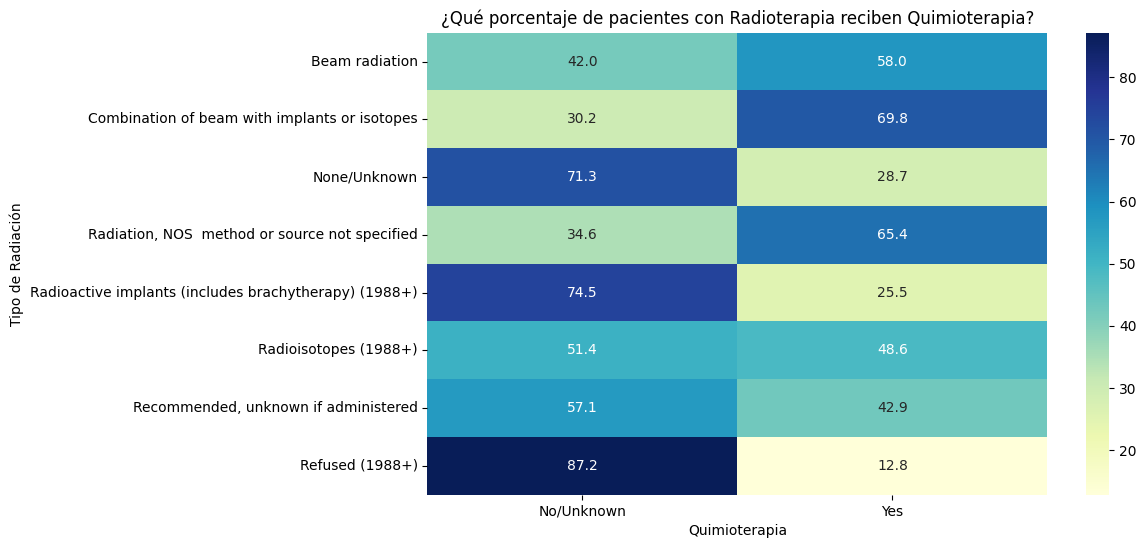

In [183]:
####
# Creamos la tabla de frecuencias
tabla_relacion = pd.crosstab(df['Radiation recode'], df['Chemotherapy recode (yes, no/unk)'], normalize='index') * 100

# Graficamos
plt.figure(figsize=(10, 6))
sns.heatmap(tabla_relacion, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title('¿Qué porcentaje de pacientes con Radioterapia reciben Quimioterapia?')
plt.xlabel('Quimioterapia')
plt.ylabel('Tipo de Radiación')
plt.show()

In [184]:
df[(df['Reason no cancer-directed surgery'] == "Not recommended") & (df["Radiation recode"] != "None/Unknown") ][["Radiation recode","vital_status"]].value_counts()

Radiation recode                                       vital_status
Beam radiation                                         dead            30627
                                                       Alive           18975
Refused (1988+)                                        dead             1197
Recommended, unknown if administered                   dead              610
                                                       Alive             340
Beam radiation                                         dead_unknown      319
Refused (1988+)                                        Alive             271
Radiation, NOS  method or source not specified         dead              257
                                                       Alive             136
Radioactive implants (includes brachytherapy) (1988+)  dead               47
                                                       Alive              39
Combination of beam with implants or isotopes          dead               24
Refused 

In [185]:
# 1. Estandarizar Cirugía (Usando tus dos columnas de cirugía)
# Si hubo cirugía en 'surgery_class' y se confirmó en 'Reason...', es un SÍ.
df['surg_yesno'] = df.apply(lambda x: 'S' if x['surgery_class'] != 'no intervenido' and x['Reason no cancer-directed surgery'] == 'Surgery performed' else 'N', axis=1)

# 2. Estandarizar Quimioterapia
df['chemo_yesno'] = df['Chemotherapy recode (yes, no/unk)'].map({'Yes': 'Q', 'No/Unknown': 'nQ'})

# 3. Estandarizar Radiación
# Consideramos 'SÍ' a cualquier forma de radiación activa
df['rad_yesno'] = df['Radiation recode'].apply(lambda x: 'R' if x in ['Beam radiation', 'Radioactive implants (includes brachytherapy) (1988+)', 'Combination of beam with implants or isotopes', 'Radioisotopes (1988+)', 'Radiation, NOS  method or source not specified'] else 'nR')

In [186]:
# Creamos la combinación (Ejemplo: S+Q+R significa Cirugía, Quimio y Radio)
df['tratamiento'] = df['surg_yesno'] + " + " + df['chemo_yesno'] + " + " + df['rad_yesno']

# Ejemplo de los nombres que quedarán:
# 'S + Q + R' -> Tratamiento completo
# 'N + nQ + nR' -> Sin tratamiento registrado
# 'S + nQ + nR' -> Solo cirugía

In [187]:
df = df.drop(["surg_yesno","chemo_yesno","rad_yesno"], axis=1)

In [188]:
#df["tratamiento"].value_counts()

In [189]:
#df[["tratamiento","survival_range"]]

In [190]:
#df[(df["tratamiento"]!='N + nQ + nR') & (df["vital_status"] == 'Alive')][["survival_range"]].value_counts()

In [191]:
#df[(df["tratamiento"]!='N + nQ + nR') & (df["vital_status"] == 'Alive') & (df["survival_range"] >= 60)]["survival_range"].value_counts()

In [192]:
# Definimos las dos condiciones
condicion_dead = (df['vital_status'] == 'dead')
condicion_alive_largo = (df['vital_status'] == 'Alive') & (df['survival_range'] >= 60)

# Unimos ambas con el operador OR (|)
df_filtrado = df[condicion_dead | condicion_alive_largo]

# Verificamos

#df_filtrado['vital_status'].value_counts()

In [193]:
#df[["survival_range","vital_status"]].value_counts()

In [194]:
df.columns

Index(['Race', 'Primary Site',
       'Combined Summary Stage with Expanded Regional Codes (2004+)',
       'Survival months flag', 'Vital status recode (study cutoff used)',
       'vital_status', 'Year of diagnosis', 'Radiation recode',
       'Chemotherapy recode (yes, no/unk)', 'Sex', 'Rural Code',
       'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient',
       'Total number of benign/borderline tumors for patient',
       'Sequence number', 'age_group', 'income_level', 'target_cancer_death',
       'survival_months_int', 'survival_range', 'histology_type_named',
       'tumor_category', 'surgery_class', 'Stage_Final', 'grade_clinical',
       'tratamiento'],
      dtype='object')

In [195]:
#for columnas in df:
 #   print(columnas)
 #   print(df[columnas].unique())

In [196]:
#si df.drop(["Vital status recode (study cutoff used)",'Chemotherapy recode (yes, no/unk)','Reason no cancer-directed surgery','Radiation recode'], axis=1, inplace=True)
df.drop(["Vital status recode (study cutoff used)"], axis=1, inplace=True)

In [197]:
df = df.drop(["Year of diagnosis","Sequence number","Survival months flag","surgery_class",  "Total number of benign/borderline tumors for patient"], axis=1)

In [198]:
df.columns

Index(['Race', 'Primary Site',
       'Combined Summary Stage with Expanded Regional Codes (2004+)',
       'vital_status', 'Radiation recode', 'Chemotherapy recode (yes, no/unk)',
       'Sex', 'Rural Code', 'Reason no cancer-directed surgery',
       'Total number of in situ/malignant tumors for patient', 'age_group',
       'income_level', 'target_cancer_death', 'survival_months_int',
       'survival_range', 'histology_type_named', 'tumor_category',
       'Stage_Final', 'grade_clinical', 'tratamiento'],
      dtype='object')

In [199]:
df.to_csv("../data/processed/df_betania.csv", index=False)

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167018 entries, 0 to 449668
Data columns (total 20 columns):
 #   Column                                                       Non-Null Count   Dtype 
---  ------                                                       --------------   ----- 
 0   Race                                                         167018 non-null  object
 1   Primary Site                                                 167018 non-null  object
 2   Combined Summary Stage with Expanded Regional Codes (2004+)  167018 non-null  object
 3   vital_status                                                 167018 non-null  object
 4   Radiation recode                                             167018 non-null  object
 5   Chemotherapy recode (yes, no/unk)                            167018 non-null  object
 6   Sex                                                          167018 non-null  object
 7   Rural Code                                                   167018 non-null  o